# 🔍 YOLO26l-Pose Error Bar Detection Diagnostic Tool

## Purpose
Your model is detecting data points but **not detecting error bars** (all predictions are NaN).
This notebook helps diagnose why.

## Common Causes
1. ❌ Confidence thresholds too high
2. ❌ Model not properly trained on keypoints
3. ❌ Wrong keypoint indices
4. ❌ Keypoint confidence too low
5. ❌ Model outputs but they're being filtered out

In [23]:
!pip install -U ultralytics

## 1. Setup

In [24]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Paths
TEST_IMAGES_DIR = Path('/kaggle/input/error-bar-detection/images ')
MODEL_PATH = Path('/kaggle/input/yolo-error-bar/pytorch/default/1/best.pt')  # UPDATE THIS

test_imgs = sorted(TEST_IMAGES_DIR.glob('*.png'))
print(f'Found {len(test_imgs)} test images')
print(f'Model: {MODEL_PATH}')

Found 150 test images
Model: /kaggle/input/yolo-error-bar/pytorch/default/1/best.pt


## 2. Load Model and Test on Single Image

In [20]:
# Load model
model = YOLO(str(MODEL_PATH))
print('✅ Model loaded')

# Test on first image with VERY LOW thresholds
test_img = test_imgs[0]
print(f'\nTesting on: {test_img.name}')

# Run with extremely low confidence to see everything
results = model.predict(
    source=str(test_img),
    imgsz=1280,
    conf=0.3,  # Very low - accept almost everything
    iou=0.7,
    verbose=True,  # Show details
    save=False
)

result = results[0]
print(f'\n✅ Inference complete')

✅ Model loaded

Testing on: 043d958d-c6fb-407e-ba05-19ccf09017a2.png

image 1/1 /kaggle/input/error-bar-detection/images /043d958d-c6fb-407e-ba05-19ccf09017a2.png: 736x1280 53 error_bars, 75.9ms
Speed: 6.0ms preprocess, 75.9ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

✅ Inference complete


## 3. Inspect Raw Model Outputs

In [22]:
print('='*80)
print('RAW MODEL OUTPUT INSPECTION')
print('='*80)

# Check boxes
boxes = getattr(result, 'boxes', None)
print(f'\n📦 Boxes: {boxes}')
if boxes is not None:
    xyxy = getattr(boxes, 'xyxy', None)
    conf = getattr(boxes, 'conf', None)
    cls = getattr(boxes, 'cls', None)
    
    if xyxy is not None:
        print(f'   Number of detections: {len(xyxy)}')
        if conf is not None:
            conf_np = conf.cpu().numpy() if hasattr(conf, 'cpu') else np.array(conf)
            print(f'   Confidence range: {conf_np.min():.3f} - {conf_np.max():.3f}')
            print(f'   Confidence mean: {conf_np.mean():.3f}')
else:
    print('   ❌ No boxes found!')

# Check keypoints
keypoints = getattr(result, 'keypoints', None)
print(f'\n🎯 Keypoints: {keypoints}')
if keypoints is not None:
    kp_data = getattr(keypoints, 'data', None)
    kp_xy = getattr(keypoints, 'xy', None)
    kp_conf = getattr(keypoints, 'conf', None)
    
    print(f'   Has data: {kp_data is not None}')
    print(f'   Has xy: {kp_xy is not None}')
    print(f'   Has conf: {kp_conf is not None}')
    
    if kp_xy is not None:
        kp_xy_np = kp_xy.cpu().numpy() if hasattr(kp_xy, 'cpu') else np.array(kp_xy)
        print(f'   Keypoint shape: {kp_xy_np.shape}')
        print(f'   Expected: (num_detections, 3, 2) for [upper, lower, point]')
        
        if kp_conf is not None:
            kp_conf_np = kp_conf.cpu().numpy() if hasattr(kp_conf, 'cpu') else np.array(kp_conf)
            print(f'\n   Keypoint confidence shape: {kp_conf_np.shape}')
            print(f'   Keypoint confidence range: {kp_conf_np.min():.3f} - {kp_conf_np.max():.3f}')
            print(f'   Keypoint confidence mean: {kp_conf_np.mean():.3f}')
            
            # Per-keypoint analysis
            print(f'\n   Per-keypoint confidence:')
            for k in range(min(kp_conf_np.shape[1], 3)):
                kp_confs = kp_conf_np[:, k]
                print(f'      Keypoint {k}: mean={kp_confs.mean():.3f}, '
                      f'min={kp_confs.min():.3f}, max={kp_confs.max():.3f}, '
                      f'above_0.3={np.sum(kp_confs > 0.3)}/{len(kp_confs)}')
else:
    print('   ❌ No keypoints found!')
    print('   This means your model is NOT outputting pose keypoints!')
    print('   Possible issues:')
    print('      - Model is not a YOLO-Pose model')
    print('      - Model was not trained properly')
    print('      - Wrong model file loaded')

RAW MODEL OUTPUT INSPECTION

📦 Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.7775, 0.7377, 0.6619, 0.6490, 0.6410, 0.6246, 0.6210, 0.6154, 0.5956, 0.5931, 0.5914, 0.5675, 0.5551, 0.5472, 0.5467, 0.5400, 0.5127, 0.5033, 0.4935, 0.4912, 0.4834, 0.4814, 0.4797, 0.4793, 0.4610, 0.4604, 0.4551, 0.4528, 0.4459, 0.4399, 0.4384, 0.4370, 0.4176, 0.4061, 0.3952, 0.3754, 0.3727, 0.3694, 0.3627,
        0.3618, 0.3573, 0.3565, 0.3481, 0.3478, 0.3469, 0.3411, 0.3363, 0.3308, 0.3218, 0.3194, 0.3137, 0.3121, 0.3048], device='cuda:0')
data: tensor([[5.8241e+02, 5.4203e+02, 6.7081e+02, 6.3106e+02, 7.7745e-01, 0.0000e+00],
        [1.0711e+03, 5.4923e+02, 1.1582e+03, 6.3770e+02, 7.3772e-01, 0.0000e+00],
        [5.8175e+02, 1.8399

## 4. Detailed Keypoint Inspection

In [14]:
if keypoints is not None and kp_xy is not None:
    print('='*80)
    print('DETAILED KEYPOINT ANALYSIS')
    print('='*80)
    
    kp_xy_np = kp_xy.cpu().numpy() if hasattr(kp_xy, 'cpu') else np.array(kp_xy)
    kp_conf_np = kp_conf.cpu().numpy() if hasattr(kp_conf, 'cpu') else np.array(kp_conf)
    
    # Show first 5 detections
    num_show = min(5, len(kp_xy_np))
    print(f'\nShowing first {num_show} detections:')
    
    for i in range(num_show):
        print(f'\nDetection {i}:')
        for k in range(min(kp_xy_np.shape[1], 3)):
            kp_name = ['UPPER', 'LOWER', 'POINT'][k]
            x, y = kp_xy_np[i, k, :2]
            conf = kp_conf_np[i, k] if kp_conf_np.size else 0.0
            
            # Check if valid
            is_valid = np.isfinite(x) and np.isfinite(y)
            is_visible = conf > 0.3
            
            status = '✅' if (is_valid and is_visible) else '❌'
            print(f'   {status} {kp_name}: x={x:.1f}, y={y:.1f}, conf={conf:.3f}')
    
    # Statistics
    print('\n' + '='*80)
    print('KEYPOINT STATISTICS (ALL DETECTIONS)')
    print('='*80)
    
    for k in range(min(kp_xy_np.shape[1], 3)):
        kp_name = ['UPPER', 'LOWER', 'POINT'][k]
        kp_confs = kp_conf_np[:, k]
        kp_xs = kp_xy_np[:, k, 0]
        kp_ys = kp_xy_np[:, k, 1]
        
        valid = np.isfinite(kp_xs) & np.isfinite(kp_ys)
        above_03 = kp_confs > 0.3
        above_05 = kp_confs > 0.5
        
        print(f'\n{kp_name}:')
        print(f'   Valid coordinates: {np.sum(valid)}/{len(valid)} ({100*np.sum(valid)/len(valid):.1f}%)')
        print(f'   Confidence > 0.3: {np.sum(above_03)}/{len(above_03)} ({100*np.sum(above_03)/len(above_03):.1f}%)')
        print(f'   Confidence > 0.5: {np.sum(above_05)}/{len(above_05)} ({100*np.sum(above_05)/len(above_05):.1f}%)')
        print(f'   Mean confidence: {kp_confs.mean():.3f}')
        
        # Check if keypoint is actually being used
        usable = valid & above_03
        if np.sum(usable) == 0:
            print(f'   ⚠️ WARNING: NO USABLE {kp_name} KEYPOINTS!')
            if np.sum(valid) == 0:
                print(f'      → All coordinates are NaN/inf')
            elif np.sum(above_03) == 0:
                print(f'      → All confidences below 0.3')
                print(f'      → Try lowering KEYPOINT_CONF threshold')
else:
    print('\n❌ Cannot analyze keypoints - none detected!')

DETAILED KEYPOINT ANALYSIS

Showing first 5 detections:

Detection 0:
   ❌ UPPER: x=626.5, y=581.3, conf=0.025
   ❌ LOWER: x=626.5, y=592.7, conf=0.033
   ✅ POINT: x=626.6, y=586.7, conf=0.995

Detection 1:
   ❌ UPPER: x=1114.4, y=587.4, conf=0.018
   ❌ LOWER: x=1114.3, y=598.7, conf=0.030
   ✅ POINT: x=1114.5, y=592.7, conf=0.995

Detection 2:
   ❌ UPPER: x=626.3, y=222.7, conf=0.053
   ❌ LOWER: x=626.3, y=234.2, conf=0.056
   ✅ POINT: x=626.5, y=228.3, conf=0.996

Detection 3:
   ❌ UPPER: x=461.5, y=694.9, conf=0.017
   ❌ LOWER: x=461.4, y=713.7, conf=0.014
   ✅ POINT: x=461.8, y=705.9, conf=0.997

Detection 4:
   ❌ UPPER: x=546.9, y=240.5, conf=0.010
   ❌ LOWER: x=546.7, y=255.4, conf=0.015
   ✅ POINT: x=546.7, y=247.5, conf=0.998

KEYPOINT STATISTICS (ALL DETECTIONS)

UPPER:
   Valid coordinates: 53/53 (100.0%)
   Confidence > 0.3: 3/53 (5.7%)
   Confidence > 0.5: 2/53 (3.8%)
   Mean confidence: 0.058

LOWER:
   Valid coordinates: 53/53 (100.0%)
   Confidence > 0.3: 4/53 (7.5%)
   

## 5. Threshold Testing

In [15]:
if keypoints is not None and kp_conf is not None:
    print('='*80)
    print('THRESHOLD SENSITIVITY ANALYSIS')
    print('='*80)
    
    kp_conf_np = kp_conf.cpu().numpy() if hasattr(kp_conf, 'cpu') else np.array(kp_conf)
    
    print('\nHow many keypoints pass different confidence thresholds?')
    print('(This helps you choose the right KEYPOINT_CONF value)\n')
    
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    results = []
    for thresh in thresholds:
        row = {'threshold': thresh}
        for k in range(min(kp_conf_np.shape[1], 3)):
            kp_name = ['upper', 'lower', 'point'][k]
            count = np.sum(kp_conf_np[:, k] > thresh)
            pct = 100 * count / len(kp_conf_np)
            row[kp_name] = f'{count} ({pct:.1f}%)'
        results.append(row)
    
    df = pd.DataFrame(results)
    print(df.to_string(index=False))
    
    print('\n💡 Recommendations:')
    
    # Check upper keypoints
    upper_confs = kp_conf_np[:, 0]
    lower_confs = kp_conf_np[:, 1]
    
    upper_03 = np.sum(upper_confs > 0.3)
    lower_03 = np.sum(lower_confs > 0.3)
    
    if upper_03 == 0 and lower_03 == 0:
        print('   ❌ NO error bar keypoints above 0.3 confidence!')
        print('   → Try KEYPOINT_CONF = 0.1 or 0.15')
        
        best_thresh = None
        for thresh in [0.1, 0.15, 0.2, 0.25]:
            if np.sum(upper_confs > thresh) > 0 or np.sum(lower_confs > thresh) > 0:
                best_thresh = thresh
                break
        
        if best_thresh:
            print(f'   → Suggested: KEYPOINT_CONF = {best_thresh}')
        else:
            print('   ⚠️ CRITICAL: Even at 0.1 threshold, no error bars detected!')
            print('   → Your model may not be trained properly')
    elif upper_03 < len(upper_confs) * 0.3:  # Less than 30% pass
        print('   ⚠️ Very few error bar keypoints above 0.3')
        print('   → Try KEYPOINT_CONF = 0.2')
    else:
        print('   ✅ KEYPOINT_CONF = 0.3 seems reasonable')
else:
    print('\n❌ Cannot test thresholds - no keypoints detected!')

THRESHOLD SENSITIVITY ANALYSIS

How many keypoints pass different confidence thresholds?
(This helps you choose the right KEYPOINT_CONF value)

 threshold    upper    lower       point
       0.1 3 (5.7%) 4 (7.5%) 53 (100.0%)
       0.2 3 (5.7%) 4 (7.5%) 53 (100.0%)
       0.3 3 (5.7%) 4 (7.5%) 53 (100.0%)
       0.4 2 (3.8%) 3 (5.7%) 53 (100.0%)
       0.5 2 (3.8%) 3 (5.7%) 53 (100.0%)
       0.6 2 (3.8%) 3 (5.7%) 53 (100.0%)
       0.7 2 (3.8%) 3 (5.7%) 53 (100.0%)
       0.8 2 (3.8%) 3 (5.7%)  52 (98.1%)
       0.9 1 (1.9%) 1 (1.9%)  52 (98.1%)

💡 Recommendations:
   ⚠️ Very few error bar keypoints above 0.3
   → Try KEYPOINT_CONF = 0.2


## 6. Visualize Raw Detections

Creating visualization...


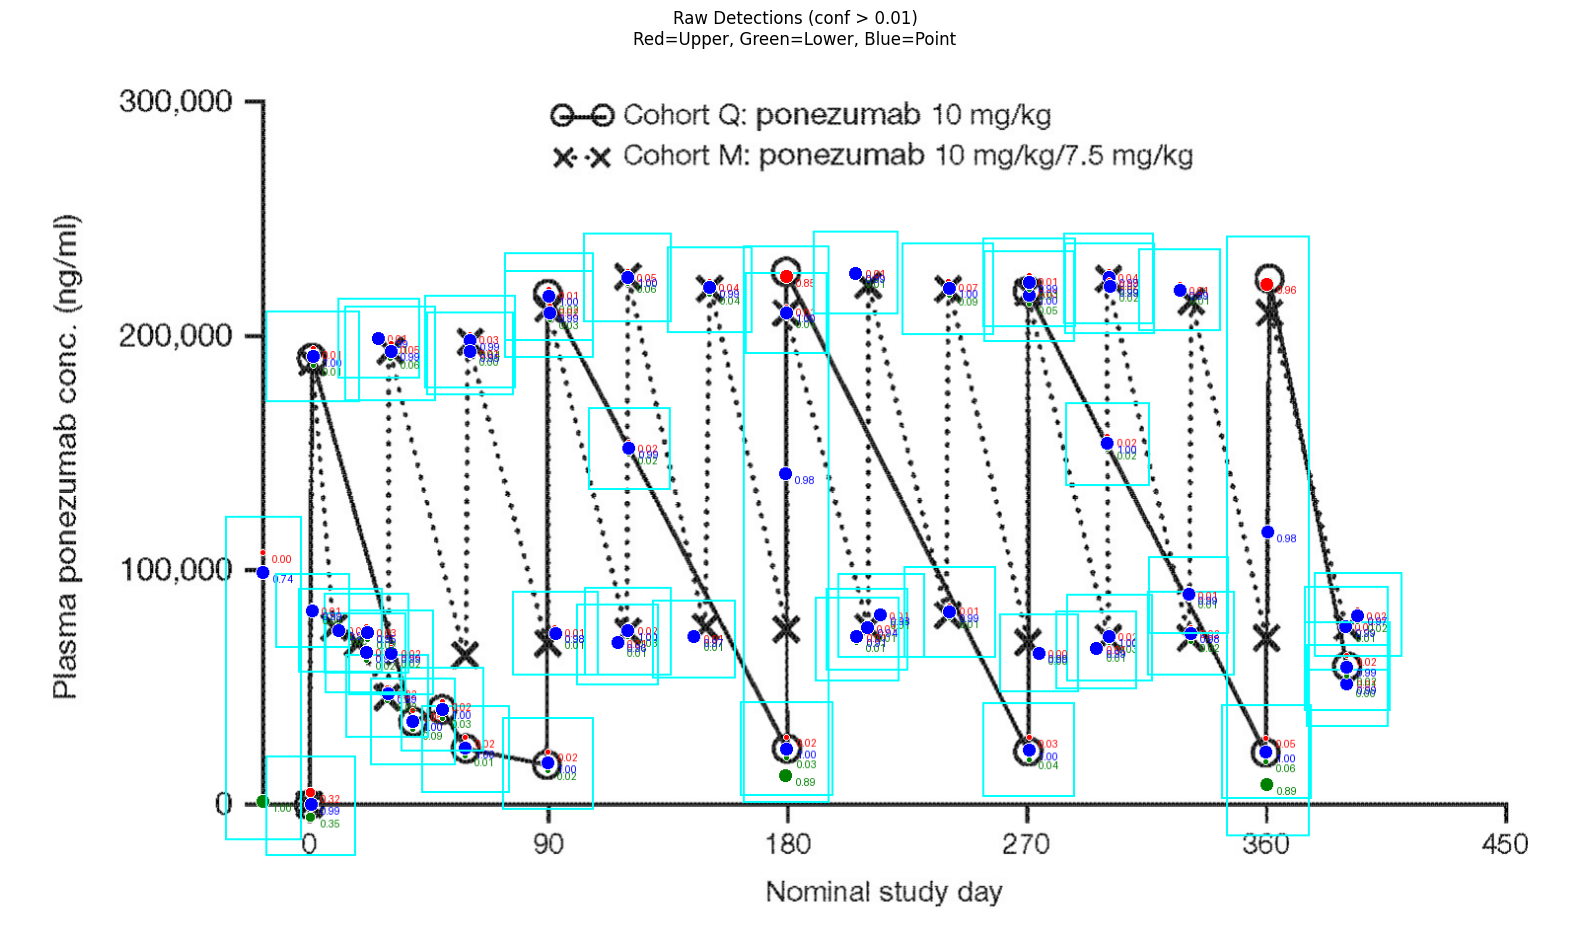


 Legend:
   🔴 Red dots = Upper error bar endpoints
   🟢 Green dots = Lower error bar endpoints
   🔵 Blue dots = Data points
   📦 Cyan boxes = Detection bounding boxes
   Numbers = Keypoint confidence scores


In [16]:
if keypoints is not None and kp_xy is not None:
    print('Creating visualization...')
    
    img = Image.open(test_img).convert('RGB')
    draw = ImageDraw.Draw(img)
    
    kp_xy_np = kp_xy.cpu().numpy() if hasattr(kp_xy, 'cpu') else np.array(kp_xy)
    kp_conf_np = kp_conf.cpu().numpy() if hasattr(kp_conf, 'cpu') else np.array(kp_conf)
    boxes_np = boxes.xyxy.cpu().numpy() if hasattr(boxes.xyxy, 'cpu') else np.array(boxes.xyxy)
    
    # Draw all detections (even low confidence)
    for i in range(len(kp_xy_np)):
        # Draw bounding box
        x1, y1, x2, y2 = boxes_np[i]
        draw.rectangle([x1, y1, x2, y2], outline='cyan', width=2)
        
        # Draw keypoints
        for k in range(min(kp_xy_np.shape[1], 3)):
            x, y = kp_xy_np[i, k, :2]
            conf = kp_conf_np[i, k]
            
            if np.isfinite(x) and np.isfinite(y):
                # Color by keypoint type
                colors = ['red', 'green', 'blue']  # upper, lower, point
                color = colors[k]
                
                # Size by confidence
                r = 3 if conf < 0.3 else (5 if conf < 0.5 else 7)
                
                draw.ellipse([x-r, y-r, x+r, y+r], fill=color, outline='white')
                
                # Draw confidence text
                draw.text((x+10, y), f'{conf:.2f}', fill=color)
    
    # Display
    plt.figure(figsize=(16, 10))
    plt.imshow(img)
    plt.title(f'Raw Detections (conf > 0.01)\nRed=Upper, Green=Lower, Blue=Point')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print('\n Legend:')
    print('   🔴 Red dots = Upper error bar endpoints')
    print('   🟢 Green dots = Lower error bar endpoints')
    print('   🔵 Blue dots = Data points')
    print('   📦 Cyan boxes = Detection bounding boxes')
    print('   Numbers = Keypoint confidence scores')
else:
    print('\n❌ Cannot visualize - no keypoints detected!')

## 7. Diagnosis Summary

In [17]:
print('='*80)
print('DIAGNOSIS SUMMARY')
print('='*80)

if boxes is None:
    print('\n❌ CRITICAL: No bounding boxes detected')
    print('   → Model is not detecting anything at all')
    print('   → Check if model file is correct')
    print('   → Try lowering CONF_THRESHOLD to 0.05')
    
elif keypoints is None:
    print('\n❌ CRITICAL: No keypoints detected')
    print('   → Model is not a YOLO-Pose model OR')
    print('   → Model was not trained with keypoints')
    print('   → SOLUTION: You need to retrain with pose keypoints enabled')
    
elif kp_xy is None:
    print('\n❌ CRITICAL: Keypoint data is None')
    print('   → Model structure issue')
    print('   → Verify model was trained as YOLO-Pose')
    
else:
    kp_conf_np = kp_conf.cpu().numpy() if hasattr(kp_conf, 'cpu') else np.array(kp_conf)
    
    upper_good = np.sum(kp_conf_np[:, 0] > 0.3)
    lower_good = np.sum(kp_conf_np[:, 1] > 0.3)
    point_good = np.sum(kp_conf_np[:, 2] > 0.3)
    
    total = len(kp_conf_np)
    
    print(f'\nDetections: {total}')
    print(f'Upper keypoints (conf > 0.3): {upper_good} ({100*upper_good/total:.1f}%)')
    print(f'Lower keypoints (conf > 0.3): {lower_good} ({100*lower_good/total:.1f}%)')
    print(f'Point keypoints (conf > 0.3): {point_good} ({100*point_good/total:.1f}%)')
    
    print('\n' + '='*80)
    print('RECOMMENDED ACTIONS')
    print('='*80)
    
    if upper_good == 0 and lower_good == 0:
        print('\n⚠️ ISSUE: No error bar keypoints with confidence > 0.3')
        print('\nSOLUTIONS (try in order):')
        print('\n1. Lower keypoint threshold:')
        print('   KEYPOINT_CONF = 0.1  # Instead of 0.3')
        
        # Find best threshold
        for thresh in [0.05, 0.1, 0.15, 0.2]:
            if np.sum(kp_conf_np[:, 0] > thresh) > 0:
                print(f'   → Try: KEYPOINT_CONF = {thresh}')
                break
        
        print('\n2. Lower detection confidence:')
        print('   CONF_THRESHOLD = 0.15  # Instead of 0.25')
        
        print('\n3. Check training:')
        print('   → Was model trained with error bar keypoints?')
        print('   → Check training labels have topBarPixelDistance/bottomBarPixelDistance')
        print('   → Verify YOLO training used task="pose" with kpt_shape=[3,2]')
        
    elif upper_good < total * 0.3 or lower_good < total * 0.3:
        print('\n⚠️ ISSUE: Low keypoint detection rate')
        print('\nSOLUTIONS:')
        print('\n1. Lower threshold slightly:')
        print('   KEYPOINT_CONF = 0.2  # Instead of 0.3')
        
        print('\n2. Enable TTA for better detection:')
        print('   USE_TTA = True')
        print('   TTA_SCALES = [0.9, 1.0, 1.1, 1.2]')
        
    else:
        print('\n✅ Keypoint detection looks good!')
        print('\nIf you still get NaN predictions, check:')
        print('   1. Are keypoints in wrong order? (swap UPPER_KPT_IDX and LOWER_KPT_IDX)')
        print('   2. Is vertical alignment check too strict?')
        print('   3. Are data points being matched correctly?')

print('\n' + '='*80)

DIAGNOSIS SUMMARY

Detections: 53
Upper keypoints (conf > 0.3): 3 (5.7%)
Lower keypoints (conf > 0.3): 4 (7.5%)
Point keypoints (conf > 0.3): 53 (100.0%)

RECOMMENDED ACTIONS

⚠️ ISSUE: Low keypoint detection rate

SOLUTIONS:

1. Lower threshold slightly:
   KEYPOINT_CONF = 0.2  # Instead of 0.3

2. Enable TTA for better detection:
   USE_TTA = True
   TTA_SCALES = [0.9, 1.0, 1.1, 1.2]

